Import Statements

Check List:
1) 1 graph comparing Swish and ReLu
2) 1 graph comparing their method and owr method
3) 1 graph showing accuracy imbalance
4) 1 graph showing VGP
5) 1 graph showing trend

You have percentage decrease and exponential decay plot as well. Use those

Getting Data

Regular Training Function - Baseline

Original Paper Algo

In [38]:
def reAlgo():

    '''model, optimizer = get_Lemodel()
    meta_losses_clean, total_loss, history_of_accuracies = [],[],[]
    step_size_for_fig = 100
    iters = H_PARAMS['num_iterations']
    a = 0.9
    meta_l,model_l, MIN = 0,0,0
    
    
    for i in tqdm(range(iters)):
        model.train()
        img, labels = next(iter(data_loader))
        meta_model = LeNet(n_out=1)
        meta_model.load_state_dict(model.state_dict())

        if torch.cuda.is_available():meta_model.cuda()

        img = gpu_avail(img, requires_grad=False)
        labels = gpu_avail(labels, requires_grad=False)

        meta_model_out  = meta_model(img)
        cel = F.binary_cross_entropy_with_logits(meta_model_out,labels, reduce=False)

        epsilon = gpu_avail(torch.zeros(cel.size()))
        sum_MM_out = torch.sum(cel* epsilon)

        meta_model.zero_grad()
        
        grads = torch.autograd.grad(sum_MM_out, (meta_model.params()), create_graph=True)
        meta_model.update_params(H_PARAMS['lr'], source_params=grads)
        
        meta_model_prime = meta_model(loaded_imgs)

        cel_prime = F.binary_cross_entropy_with_logits(meta_model_prime,loaded_lbls)
        epsilon_prime = torch.autograd.grad(cel_prime, epsilon, only_inputs=True)[0]
        
        w = torch.clamp(-epsilon_prime,min=MIN)
        LNorm = torch.sum(w)

        meta_model_out = model(img)
        cost = F.binary_cross_entropy_with_logits(meta_model_out, labels, reduce=False)

        if LNorm != 0:
            w = w / LNorm
        sum_MM_out = torch.sum(cost * w)

        optimizer.zero_grad()
        sum_MM_out.backward()
        optimizer.step()

        meta_l = a * meta_l + (1 - a) * cel_prime.item()
        meta_losses_clean.append(meta_l / (1 - a**(i+1)))

        model_l = a *model_l + (1 - a)* sum_MM_out.item()
        total_loss.append(model_l/(1 - a**(i+1)))

        if i % step_size_for_fig == 0:
            model.eval()

            preds = []
            for itr,(test_img, test_label) in enumerate(test_loader):
                test_img = gpu_avail(test_img, requires_grad=False)
                test_label = gpu_avail(test_label, requires_grad=False)

                output = model(test_img)
                predicted = (F.sigmoid(output) > 0.5)
                float_prediction = (predicted.int() == test_label.int()).float()
                preds.append(float_prediction)

            accuracy = torch.cat(preds,dim=0).mean()
            history_of_accuracies.append(np.array([i,accuracy])[None])

            IPython.display.clear_output()

            fig, axes = plt.subplots(1, 2, figsize=(15,5))
            ax1, ax2 = axes.ravel()

            ax1.plot(meta_losses_clean, label='meta_losses_clean')
            ax1.plot(total_loss, label='total_loss')
            ax1.set_ylabel("Losses")
            ax1.set_xlabel("Iteration")
            ax1.legend()

            logs = np.concatenate(accuracy_log, axis=0)
            ax2.plot(logs[:,0],logs[:,1])
            ax2.set_title('Re-weighted Training - 80% Imbalance')
            ax2.set_ylabel('Accuracy')
            ax2.set_xlabel('Iteration')
            # plt.show()

    mean = np.mean(logs[-6:-1, 1])
    return mean'''
def train_lre():
    net, opt = get_Lemodel()
    
    meta_losses_clean = []
    net_losses = []
    plot_step = 100

    smoothing_alpha = 0.9
    
    meta_l = 0
    net_l = 0
    accuracy_log = []
    for i in tqdm(range(H_PARAMS['num_iterations'])):
        net.train()
        # Line 2 get batch of data
        image, labels = next(iter(data_loader))
        # since validation data is small I just fixed them instead of building an iterator
        # initialize a dummy network for the meta learning of the weights
        meta_net = LeNet(n_out=1)
        meta_net.load_state_dict(net.state_dict())

        if torch.cuda.is_available():
            meta_net.cuda()

        image = to_var(image, requires_grad=False)
        labels = to_var(labels, requires_grad=False)

        # Lines 4 - 5 initial forward pass to compute the initial weighted loss
        y_f_hat  = meta_net(image)
        cost = F.binary_cross_entropy_with_logits(y_f_hat,labels, reduce=False)
        eps = to_var(torch.zeros(cost.size()))
        l_f_meta = torch.sum(cost * eps)

        meta_net.zero_grad()
        
        # Line 6 perform a parameter update
        grads = torch.autograd.grad(l_f_meta, (meta_net.params()), create_graph=True)
        meta_net.update_params(H_PARAMS['lr'], source_params=grads)
        
        # Line 8 - 10 2nd forward pass and getting the gradients with respect to epsilon
        y_g_hat = meta_net(loaded_imgs)

        l_g_meta = F.binary_cross_entropy_with_logits(y_g_hat,loaded_lbls)

        grad_eps = torch.autograd.grad(l_g_meta, eps, only_inputs=True)[0]
        
        # Line 11 computing and normalizing the weights
        w_tilde = torch.clamp(-grad_eps,min=0)
        norm_c = torch.sum(w_tilde)

        if norm_c != 0:
            w = w_tilde / norm_c
        else:
            w = w_tilde

        # Lines 12 - 14 computing for the loss with the computed weights
        # and then perform a parameter update
        y_f_hat = net(image)
        cost = F.binary_cross_entropy_with_logits(y_f_hat, labels, reduce=False)
        l_f = torch.sum(cost * w)

        opt.zero_grad()
        l_f.backward()
        opt.step()

        meta_l = smoothing_alpha *meta_l + (1 - smoothing_alpha)* l_g_meta.item()
        meta_losses_clean.append(meta_l/(1 - smoothing_alpha**(i+1)))

        net_l = smoothing_alpha *net_l + (1 - smoothing_alpha)* l_f.item()
        net_losses.append(net_l/(1 - smoothing_alpha**(i+1)))

        if i % plot_step == 0:
            net.eval()

            acc = []
            for itr,(test_img, test_label) in enumerate(test_loader):
                test_img = to_var(test_img, requires_grad=False)
                test_label = to_var(test_label, requires_grad=False)

                output = net(test_img)
                predicted = (F.sigmoid(output) > 0.5).int()

                acc.append((predicted.int() == test_label.int()).float())

            accuracy = torch.cat(acc,dim=0).mean()
            accuracy_log.append(np.array([i,accuracy])[None])


            IPython.display.clear_output()
            fig, axes = plt.subplots(1, 2, figsize=(13,5))
            ax1, ax2 = axes.ravel()

            ax1.plot(meta_losses_clean, label='meta_losses_clean')
            ax1.plot(net_losses, label='net_losses')
            ax1.set_ylabel("Losses")
            ax1.set_xlabel("Iteration")
            ax1.legend()

            acc_log = np.concatenate(accuracy_log, axis=0)
            ax2.plot(acc_log[:,0],acc_log[:,1])
            ax2.set_ylabel('Accuracy')
            ax2.set_xlabel('Iteration')
            plt.show()
            
        # return accuracy
    return np.mean(acc_log[-6:-1, 1])

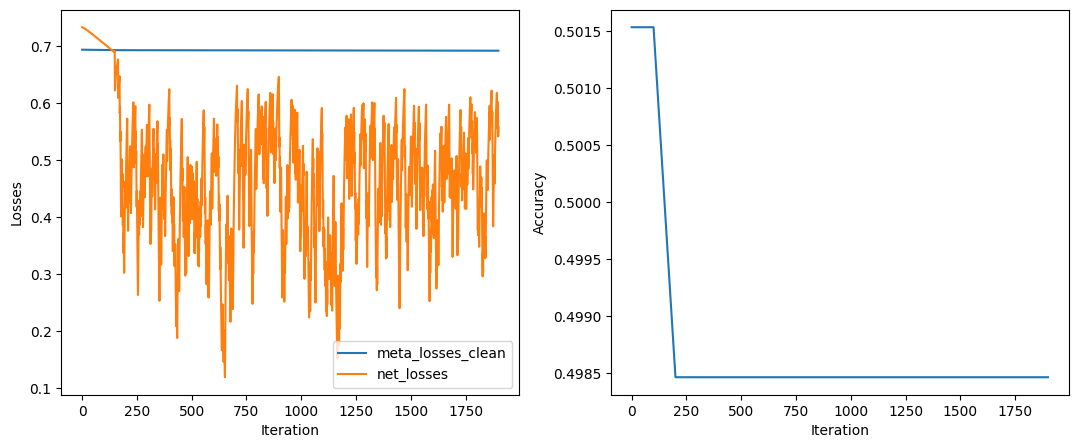

100%|██████████| 2000/2000 [04:37<00:00,  7.21it/s]


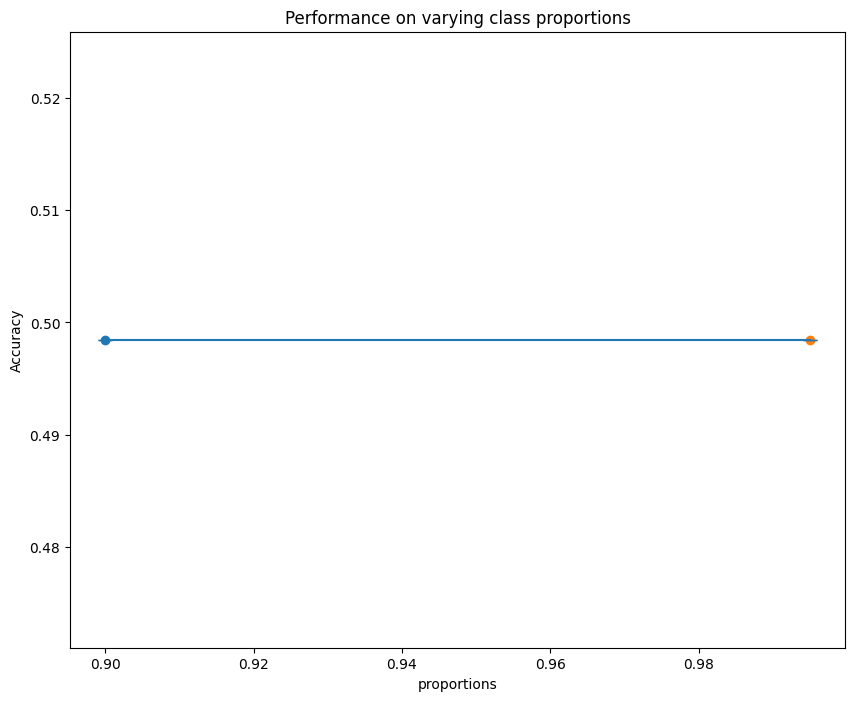

In [39]:
# import time
# num_repeats = 1
# # proportions = [0.9,0.95, 0.98, 0.99, 0.995]
# # proportions = [0.8]
# proportions = [0.8,0.9,0.95,0.99]
# # proportions = [(0.90 + 0.95)/2, (0.95+0.99)/2]
# history_of_accuracies = {}
# start_time = time.time()
# batches = H_PARAMS['batch_size']
# for prop in proportions:
#     data_loader = get_mnist_loader(batches, classes=[8, 0], proportion=prop, mode="train")
#     imgs = gpu_avail(data_loader.dataset.data_val, requires_grad=False)
#     lbls = gpu_avail(data_loader.dataset.labels_val, requires_grad=False)
    
#     for k in range(num_repeats):
#         accuracy = reAlgo()
#         if prop in history_of_accuracies:
#             history_of_accuracies[prop].append(accuracy)
#         else:
#             history_of_accuracies[prop] = [accuracy]

# # plt.figure(figsize=(10,4))
# for prop in proportions:
#     accuracies = history_of_accuracies[prop]
#     # plt.scatter([prop] * len(accuracies), accuracies)

# # plot the trend line with error bars that correspond to standard deviation
# accuracies_mean = np.array([np.mean(v) for _,v in sorted(history_of_accuracies.items())])
# accuracies_std = np.array([np.std(v) for _,v in sorted(history_of_accuracies.items())])
# print(f"Diff = {time.time() - start_time}")
# plt.errorbar(proportions, accuracies_mean, yerr=accuracies_std)
# plt.title('Accuracies with imbalance proportions')
# plt.xlabel('Imbalance Proportions')
# plt.ylabel('Accuracies')
# plt.show()

num_repeats = 1
proportions = [0.9,0.995]
accuracy_log = {}

for prop in proportions:
    data_loader = get_mnist_loader(H_PARAMS['batch_size'], classes=[9, 4], proportion=prop, mode="train")
    val_data = to_var(data_loader.dataset.data_val, requires_grad=False)
    val_labels = to_var(data_loader.dataset.labels_val, requires_grad=False)
    
    for k in range(num_repeats):
        accuracy = train_lre()
        
        if prop in accuracy_log:
            accuracy_log[prop].append(accuracy)
        else:
            accuracy_log[prop] = [accuracy]

plt.figure(figsize=(10,8))
for prop in proportions:
    accuracies = accuracy_log[prop]
    plt.scatter([prop] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(accuracy_log.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(accuracy_log.items())])
plt.errorbar(proportions, accuracies_mean, yerr=accuracies_std)
plt.title('Performance on varying class proportions')
plt.xlabel('proportions')
plt.ylabel('Accuracy')
plt.show()

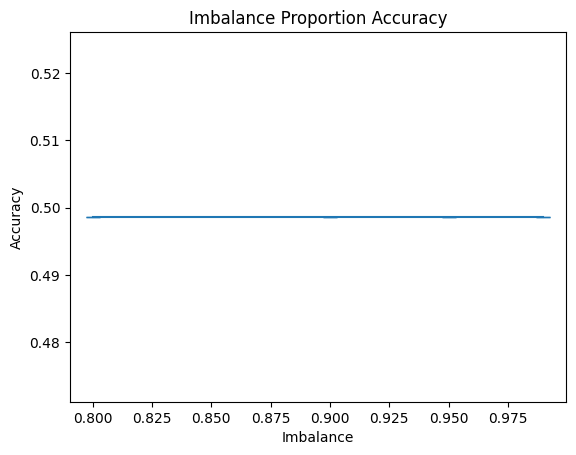

In [37]:
plt.errorbar(proportions, accuracies_mean, yerr=accuracies_std)
plt.title('Imbalance Proportion Accuracy')
plt.xlabel('Imbalance')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
acc = [0.74, 0.52,0.92,0.76,0.61]
x = [0.9,0.925,0.95,0.97,0.99]
plt.scatter(x,acc)
plt.title('Accuracies with imbalance proportions')
plt.xlabel('Imbalance Proportions')
plt.ylabel('Accuracies')

In [32]:
print(accuracies_mean)
theirs = [98,97.5,97]
mine = []
x = [0.9,0.95,0.99]

[0.49862657 0.49862657 0.49862657]
